**End-to-end Machine Learning project**

*Let's  predict median house values in Californian districts based on features from these districts.*


# Let's import a few common modules

- MatplotLib plots figures inline
- Create a function to save the figures
- Check that Python installed version to be 3.5 or later
- Check that Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Get the Data

## Download the Data

In [30]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [31]:
fetch_housing_data()

In [32]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

## Take a Quick Look at the Data Structure

In [33]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [34]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [35]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [36]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


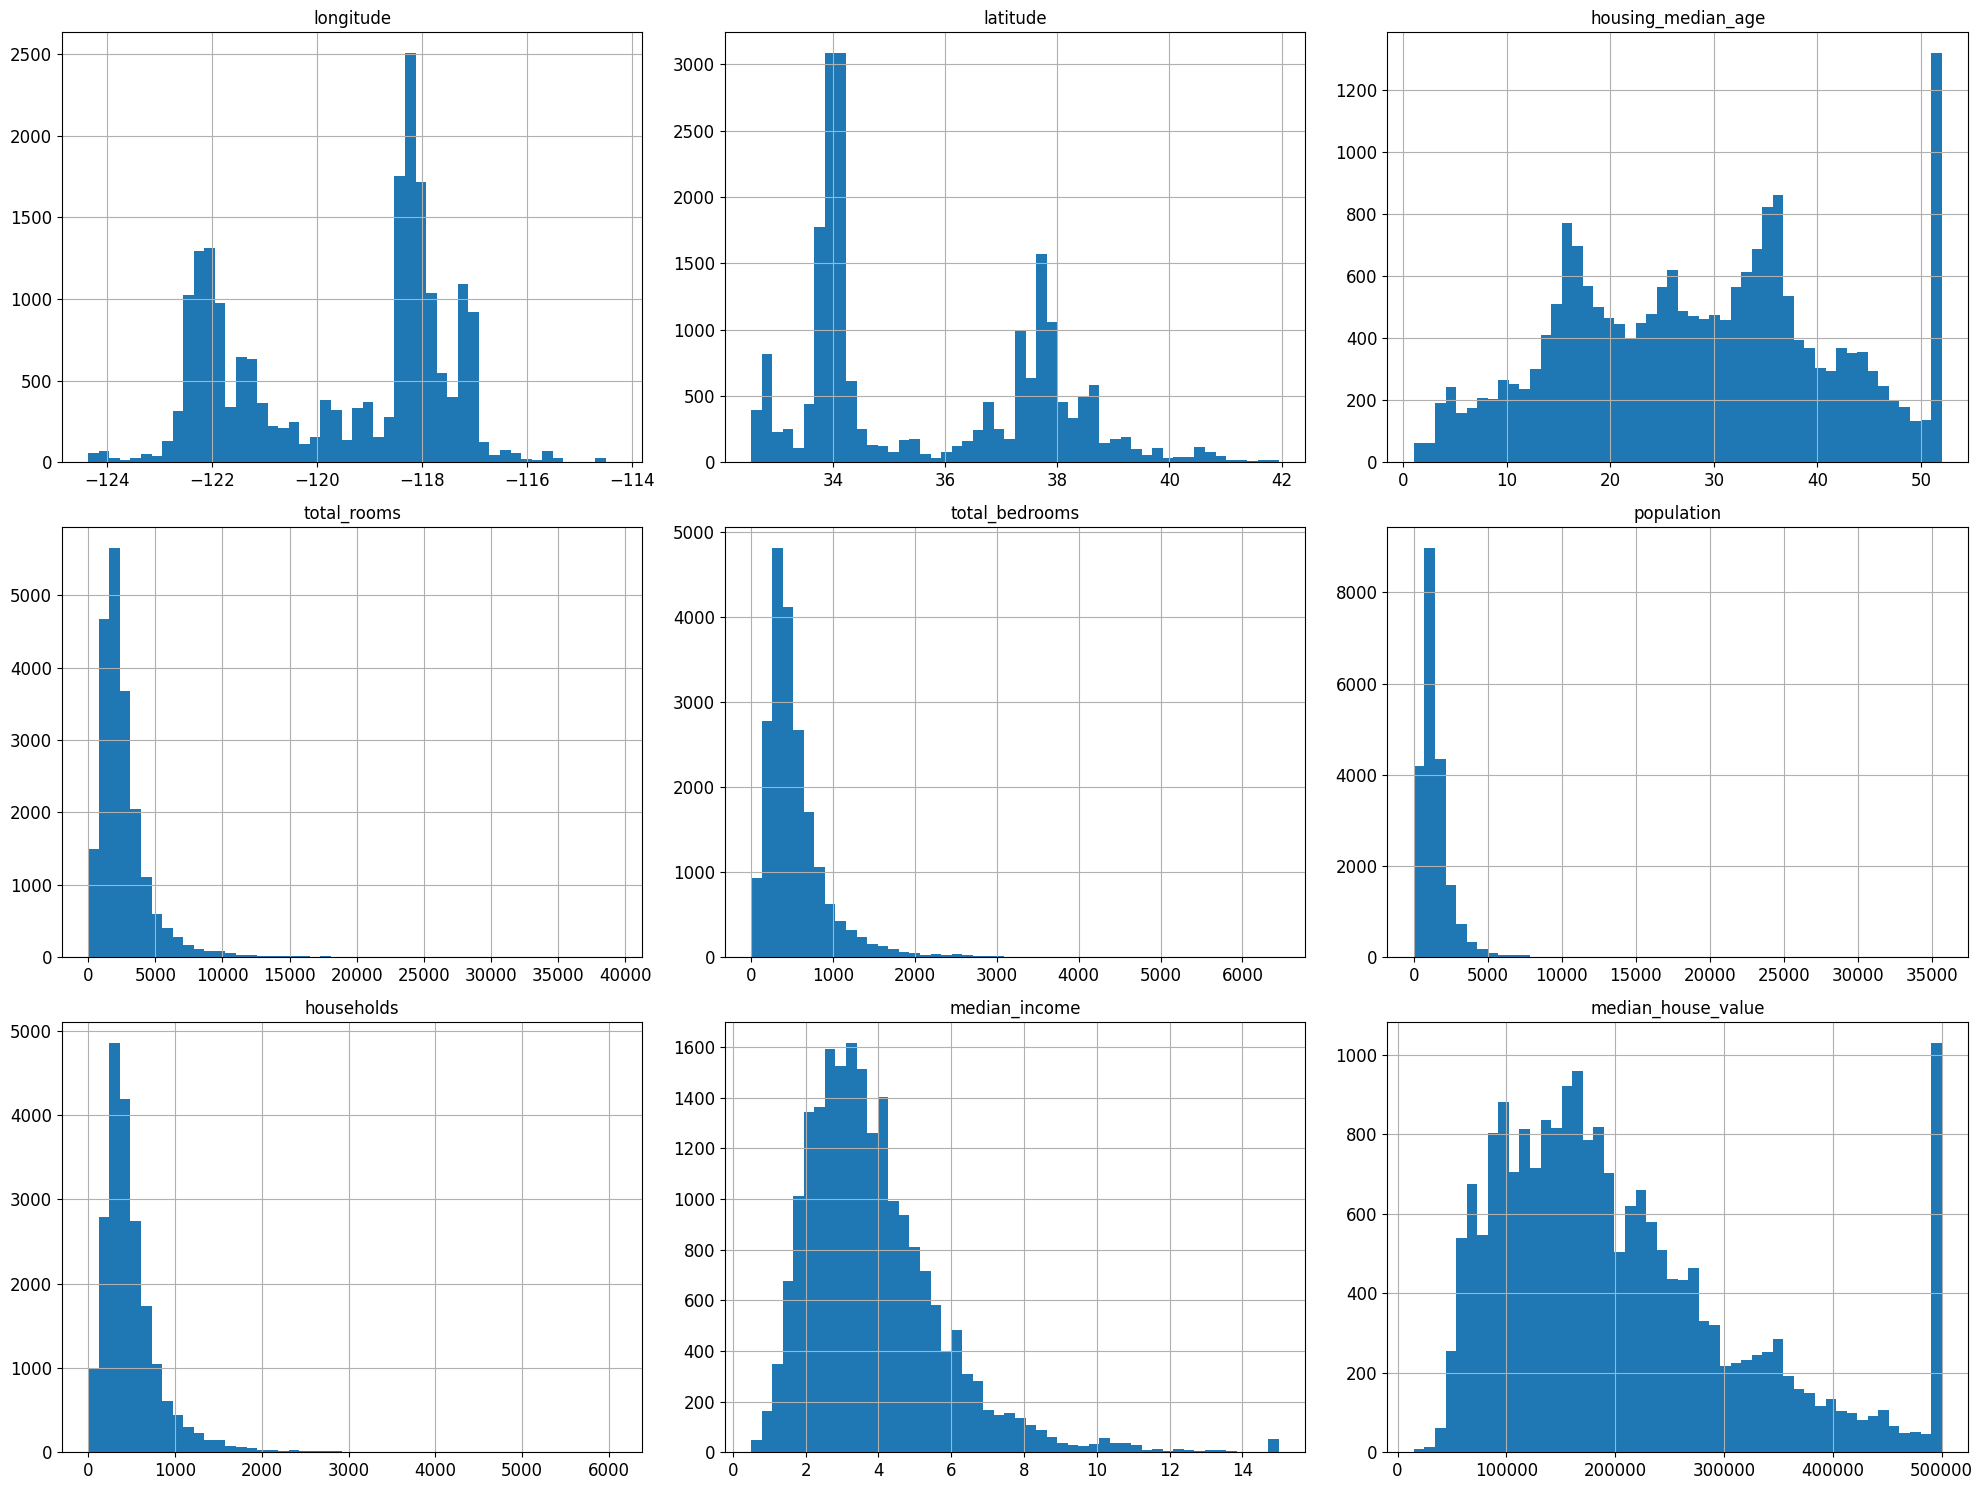

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

## Create a Test Set

In [38]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [39]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [40]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [41]:
len(test_set)

4128

In [42]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


In [43]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [44]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<Axes: >

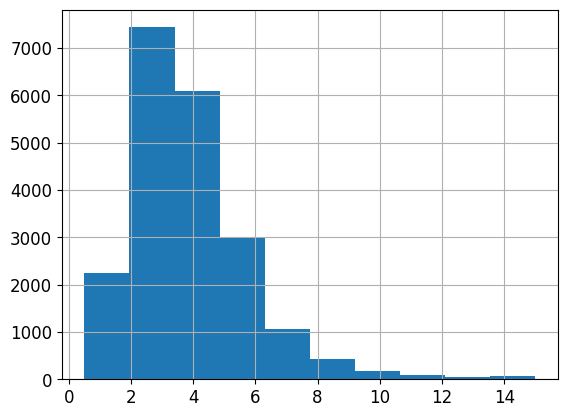

In [45]:
housing["median_income"].hist()

In [46]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [47]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<Axes: >

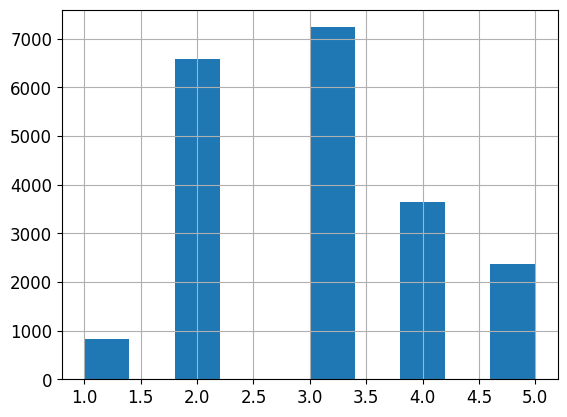

In [48]:
housing["income_cat"].hist()

# Let's do some visualization

## Visualizing Geographical Data

Saving figure bad_visualization_plot


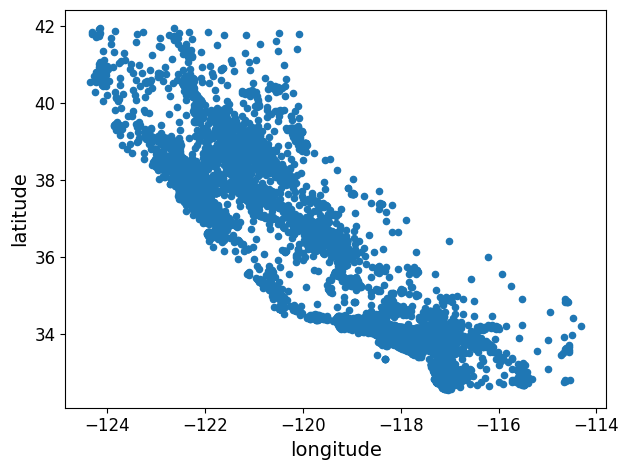

In [49]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

Saving figure better_visualization_plot


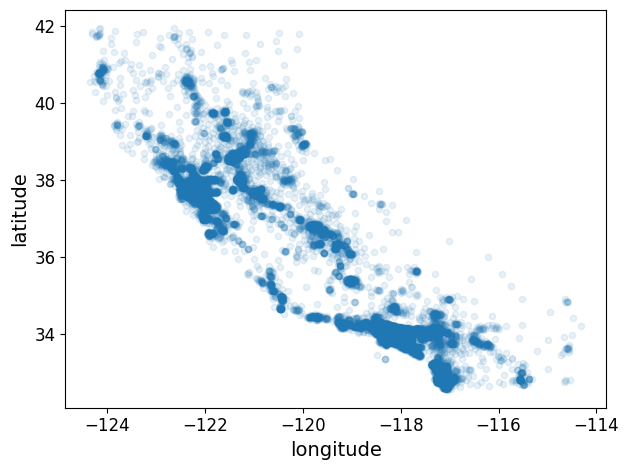

In [50]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

Saving figure housing_prices_scatterplot


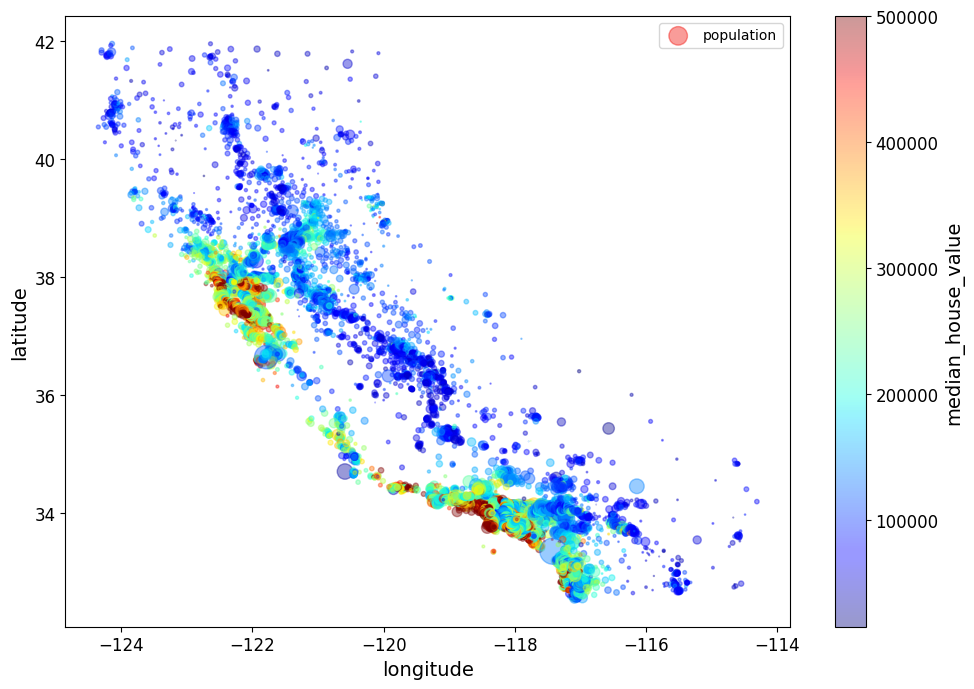

In [51]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

## Let's create new features (Feature Engineering)

In [52]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [53]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

<ipython-input-53-51a0e6bf2eb4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

In [54]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909,5.429000,0.213039,3.070655
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874,2.474173,0.057983,10.386050
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000,4.440716,0.175427,2.429741
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000,5.229129,0.203162,2.818116
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000,6.052381,0.239821,3.282261
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the Data for Machine Learning Algorithms

In [55]:
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1) # drop labels for training set


## Data Cleaning


```python
housing.dropna(subset=["total_bedrooms"])    # option 1
housing.drop("total_bedrooms", axis=1)       # option 2
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)
```

To demonstrate each of them, let's create a copy of the housing dataset, but keeping only the rows that contain at least one null. Then it will be easier to visualize exactly what each option does:

In [56]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,NEAR BAY,3,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,NEAR BAY,2,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,NEAR BAY,2,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,NEAR BAY,4,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,NEAR BAY,3,4.633540,NaN,2.403727


In [57]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household


In [58]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,570.0,218.0,4.3750,NEAR BAY,3,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,732.0,259.0,1.6196,NEAR BAY,2,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,3741.0,1273.0,2.5762,NEAR BAY,2,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,384.0,146.0,4.9489,NEAR BAY,4,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,387.0,161.0,3.9063,NEAR BAY,3,4.633540,NaN,2.403727


In [59]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3

In [60]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,NEAR BAY,3,5.761468,NaN,2.614679
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,NEAR BAY,2,3.830116,NaN,2.826255
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,NEAR BAY,2,4.048704,NaN,2.938727
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,NEAR BAY,4,6.102740,NaN,2.630137
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,NEAR BAY,3,4.633540,NaN,2.403727


In [61]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:

In [62]:
housing_num = housing.drop("ocean_proximity", axis=1)
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [63]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [64]:
imputer.statistics_

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        3.00000000e+00,  5.22912879e+00,  2.03162434e-01,  2.81811565e+00])

Check that this is the same as manually computing the median of each attribute:

In [65]:
housing_num.median().values

<ipython-input-65-8050cbb6f664>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  housing_num.median().values


array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        5.22912879e+00,  2.03162434e-01,  2.81811565e+00])

Transform the training set:

In [66]:
X = imputer.transform(housing_num)

In [67]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [68]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
290,-122.16,37.77,47.0,1256.0,435.0,570.0,218.0,4.3750,3.0,5.761468,0.203162,2.614679
341,-122.17,37.75,38.0,992.0,435.0,732.0,259.0,1.6196,2.0,3.830116,0.203162,2.826255
538,-122.28,37.78,29.0,5154.0,435.0,3741.0,1273.0,2.5762,2.0,4.048704,0.203162,2.938727
563,-122.24,37.75,45.0,891.0,435.0,384.0,146.0,4.9489,4.0,6.102740,0.203162,2.630137
696,-122.10,37.69,41.0,746.0,435.0,387.0,161.0,3.9063,3.0,4.633540,0.203162,2.403727


In [69]:
imputer.strategy

'median'

In [70]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [71]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,5.0,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,5.0,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,5.0,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,4.0,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0,6.281853,0.172096,2.181467


## Transform data

In [72]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
5,NEAR BAY
6,NEAR BAY
7,NEAR BAY
8,NEAR BAY
9,NEAR BAY


In [73]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [74]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [75]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<20640x5 sparse matrix of type '<class 'numpy.float64'>'
	with 20640 stored elements in Compressed Sparse Row format>

In [76]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [77]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [78]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

In [79]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [80]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # get the column indices

In [81]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,rooms_per_household,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,NEAR BAY,5,6.984127,0.146591,2.555556,6.984127,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,NEAR BAY,5,6.238137,0.155797,2.109842,6.238137,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,NEAR BAY,5,8.288136,0.129516,2.80226,8.288136,2.80226
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,NEAR BAY,4,5.817352,0.184458,2.547945,5.817352,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,NEAR BAY,3,6.281853,0.172096,2.181467,6.281853,2.181467


## Now let's build Pipelines for data transformation

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [83]:
housing_num_tr

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.62855945,
        -0.04959654, -1.02998783],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.32704136,
        -0.09251223, -0.8888972 ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  1.15562047,
        -0.02584253, -1.29168566],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ..., -0.09031802,
        -0.0717345 ,  0.02113407],
       [-0.87362627,  1.77823747, -0.84539315, ..., -0.04021111,
        -0.09122515,  0.09346655],
       [-0.83369581,  1.75014627, -1.00430931, ..., -0.07044252,
        -0.04368215,  0.11327519]])

In [84]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [85]:
housing_prepared

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.        ,
         1.        ,  0.        ],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87362627,  1.77823747, -0.84539315, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.        ,
         0.        ,  0.        ]])

In [86]:
housing_prepared.shape

(20640, 20)

# Long time to clean and prepare data....
# Now it's time to build your first model

In [87]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) # Model Training

LinearRegression()

In [88]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [405609.22498346 430854.01561521 381052.58199124 322812.91989427
 248104.29800217]


Print the actual prices Y and X

In [91]:
print("Labels:", list(some_labels))

Labels: [452600.0, 358500.0, 352100.0, 341300.0, 342200.0]


In [92]:
some_data_prepared

array([[-1.32783522,  1.05254828,  0.98214266, -0.8048191 , -0.97247648,
        -0.9744286 , -0.97703285,  2.34476576,  1.89012782,  0.62855945,
        -1.14993031, -0.04959654,  0.62855945, -0.04959654, -1.02998783,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-1.32284391,  1.04318455, -0.60701891,  2.0458901 ,  1.35714343,
         0.86143887,  1.66996103,  2.33223796,  1.89012782,  0.32704136,
        -0.99038135, -0.09251223,  0.32704136, -0.09251223, -0.8888972 ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-1.33282653,  1.03850269,  1.85618152, -0.53574589, -0.82702426,
        -0.82077735, -0.84363692,  1.7826994 ,  1.89012782,  1.15562047,
        -1.44586501, -0.02584253,  1.15562047, -0.02584253, -1.29168566,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [-1.33781784,  1.03850269,  1.85618152, -0.62421459, -0.71972345,
        -0.76602806, -0.73378144,  0.93296751,  

Computer the error

In [89]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

67548.28296710105

In [90]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49089.25413412552